In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd

c:\Users\jaesc2\GitHub\skforecast


In [2]:
import os
# os.environ["KERAS_BACKEND"] = "torch"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd

from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model

# set backend torch
import torch
import keras
print(keras.__version__)
print(keras.backend.backend())

3.6.0
tensorflow


# Test with Ximo

In [3]:
from skforecast.datasets import fetch_dataset
# data = fetch_dataset('air_quality_valencia_no_missing')
data = pd.read_csv(
    r"C:\Users\jaesc2\Downloads\air_quality_valencia_no_missing.csv", sep=','
)
data

,datetime,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
0,2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0
1,2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0
2,2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0
3,2019-01-01 03:00:00,10.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,30.0
4,2019-01-01 04:00:00,11.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...
43819,2023-12-31 19:00:00,3.0,0.1,6.0,18.0,8.0,26.0,47.0,1.7,246.0,7.0
43820,2023-12-31 20:00:00,3.0,0.1,6.0,19.0,7.0,27.0,49.0,1.3,239.0,6.0
43821,2023-12-31 21:00:00,3.0,0.1,4.0,15.0,5.0,22.0,55.0,1.5,247.0,4.0
43822,2023-12-31 22:00:00,3.0,0.1,5.0,13.0,5.0,20.0,57.0,1.1,246.0,5.0


In [5]:
data = data.set_index('datetime')
data.index = pd.to_datetime(data.index, format='%Y-%m-%d %H:%M:%S')
data = data.asfreq('h')
data = data.sort_index()

end_train = '2021-03-31 23:59:00'
end_validation = '2021-09-30 23:59:00'
data_train = data.loc[: end_train, :]
data_val = data.loc[end_train:end_validation, :]
data_test = data.loc[end_validation:, :]

In [5]:
data_train

,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
datetime,,,,,,,,,,
2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0
2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0
2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0
2019-01-01 03:00:00,10.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,30.0
2019-01-01 04:00:00,11.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,30.0
...,...,...,...,...,...,...,...,...,...,...
2021-03-31 19:00:00,3.0,0.1,1.0,11.0,7.0,13.0,80.0,1.3,50.0,6.0
2021-03-31 20:00:00,3.0,0.1,1.0,14.0,7.0,16.0,77.0,0.9,42.0,6.0
2021-03-31 21:00:00,3.0,0.2,1.0,15.0,10.0,17.0,71.0,0.1,27.0,8.0


# Without Exog

In [6]:
lags = 4
steps = 5
levels = ["o3", "co", "no"]

activation = "relu"
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss = keras.losses.MeanSquaredError()
recurrent_units = 100
dense_units = [128, 64]

model = create_and_compile_model(
    series=data,
    lags=lags,
    steps=steps,
    levels=levels,
    # exog=data[exog_features],
    recurrent_units=recurrent_units,
    dense_units=dense_units,
    activation=activation,
    optimizer=optimizer,
    loss=loss,
)

model.summary()

# ==============================================================================

forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    fit_kwargs={
        "epochs": 2,  # Number of epochs to train the model.
        "batch_size": 2048,  # Batch size to train the model.
    },
)    


# Backtesting model with exogenous variables on test data 
# # ============================================================================== 
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries
 
cv = TimeSeriesFold( steps = 36, initial_train_size = len(data[:end_validation]), refit = False, allow_incomplete_fold=False)
metric, predictions = backtesting_forecaster_multiseries(
    forecaster = forecaster, 
    series = data[levels], 
    # exog = data[exog_features], 
    cv = cv, 
    metric = 'mean_absolute_error'
    )

metric

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 4, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 128)         │        12,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 64)          │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (TimeDistributed)  │ (None, 5, 3)           │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,779 (256.95 KB)

 Trainable params: 65,779 (256.95 KB)

 Non-trainable params: 0 (0.00 B)

<Functional name=functional, built=True>
False


c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


AttributeError: 'Functional' object has no attribute 'exog_in_'

In [ ]:
forecaster.fit(series = data[levels])

Using device: cuda
Epoch 1/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 629ms/step - loss: 0.0549
Epoch 2/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 822ms/step - loss: 0.0356


In [ ]:
# print(forecaster.keras_backend)
print(forecaster.X_train_dim_names_)
print(forecaster.y_train_dim_names_)
print(forecaster.series_names_in_)
print(forecaster.exog_in_)

{0: DatetimeIndex(['2011-01-09 00:00:00', '2011-01-09 01:00:00',
               '2011-01-09 02:00:00', '2011-01-09 03:00:00',
               '2011-01-09 04:00:00', '2011-01-09 05:00:00',
               '2011-01-09 06:00:00', '2011-01-09 07:00:00',
               '2011-01-09 08:00:00', '2011-01-09 09:00:00',
               ...
               '2012-12-29 03:00:00', '2012-12-29 04:00:00',
               '2012-12-29 05:00:00', '2012-12-29 06:00:00',
               '2012-12-29 07:00:00', '2012-12-29 08:00:00',
               '2012-12-29 09:00:00', '2012-12-29 10:00:00',
               '2012-12-29 11:00:00', '2012-12-29 12:00:00'],
              dtype='datetime64[ns]', name='date_time', length=17293, freq='h'), 1: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24'], 2: ['users']}
{0: DatetimeIndex(['2011-01-09 00:0

In [ ]:
forecaster.X_train_dim_names_[1]

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24']

In [ ]:
forecaster.y_train_dim_names_[2]

['users']

In [ ]:
forecaster._create_predict_inputs()

(array([[[0.04098361],
         [0.02766393],
         [0.01844262],
         [0.01434426],
         [0.00614754],
         [0.00102459],
         [0.00717213],
         [0.01229508],
         [0.03278689],
         [0.07479508],
         [0.12397541],
         [0.13831967],
         [0.14651639],
         [0.17213115],
         [0.16290984],
         [0.14036885],
         [0.1352459 ],
         [0.125     ],
         [0.12704918],
         [0.10348361],
         [0.0727459 ],
         [0.04713115],
         [0.03586066],
         [0.04918033]]]),
 [],
 [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36],
 ['users'],
 DatetimeIndex(['2012-12-31 00:00:00', '2012-12-31 01:00:00',
                '2012-12-31 02:00:00', '2012-12-31 03:00:00',
                '2012-12-31 04:00:00', '2012-12-31 05:00:00',
                '2012-12-31 06:00:

# With Exog Features

In [ ]:
exog_features = [ 'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin', 'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos', 'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day', 'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day', 'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day', 'temp', 'holiday' ]

In [6]:
data_train

,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
datetime,,,,,,,,,,
2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0
2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0
2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0
2019-01-01 03:00:00,10.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,30.0
2019-01-01 04:00:00,11.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,30.0
...,...,...,...,...,...,...,...,...,...,...
2021-03-31 19:00:00,3.0,0.1,1.0,11.0,7.0,13.0,80.0,1.3,50.0,6.0
2021-03-31 20:00:00,3.0,0.1,1.0,14.0,7.0,16.0,77.0,0.9,42.0,6.0
2021-03-31 21:00:00,3.0,0.2,1.0,15.0,10.0,17.0,71.0,0.1,27.0,8.0


In [23]:
lags = 24
steps = 36
levels = ["users"]
activation = "relu"
# optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss = keras.losses.MeanSquaredError()
recurrent_units = 100
dense_units = [128, 64]

lags = 4
steps = 5
series = ["o3", "co", "no", "so2", "pm10"]
levels = ["o3", "co", "no"]
exog = ["veloc."]

model = create_and_compile_model(
    series=data[series],
    lags=lags,
    steps=steps,
    levels=levels,
    exog=data[exog],
    recurrent_units=recurrent_units,
    dense_units=dense_units,
    activation=activation,
    # optimizer=optimizer,
    loss=loss,
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ series_input        │ (None, 4, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 100)       │     42,400 │ series_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 5, 100)    │          0 │ lstm_1[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exog_input          │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 5, 101)    │          0 │ repeat_vector_1[… │
│ (Concatenate)       │                   │            │ exog_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 5, 128)    │     13,056 │ concatenate_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 5, 64)     │      8,256 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5, 3)      │        195 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,907 (249.64 KB)

 Trainable params: 63,907 (249.64 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:

# ==============================================================================

forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    fit_kwargs={
        "epochs": 2,  # Number of epochs to train the model.
        "batch_size": 2048,  # Batch size to train the model.
    },
)    



c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [33]:
_ = forecaster.fit(series = data[series], exog = data[exog])

Using device: cuda
Epoch 1/2


c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['series_input', 'exog_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0226
Epoch 2/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0063


In [37]:
forecaster.X_train_dim_names_

{0: DatetimeIndex(['2019-01-01 04:00:00', '2019-01-01 05:00:00',
                '2019-01-01 06:00:00', '2019-01-01 07:00:00',
                '2019-01-01 08:00:00', '2019-01-01 09:00:00',
                '2019-01-01 10:00:00', '2019-01-01 11:00:00',
                '2019-01-01 12:00:00', '2019-01-01 13:00:00',
                ...
                '2023-12-31 10:00:00', '2023-12-31 11:00:00',
                '2023-12-31 12:00:00', '2023-12-31 13:00:00',
                '2023-12-31 14:00:00', '2023-12-31 15:00:00',
                '2023-12-31 16:00:00', '2023-12-31 17:00:00',
                '2023-12-31 18:00:00', '2023-12-31 19:00:00'],
               dtype='datetime64[ns]', name='datetime', length=43816, freq='h'),
 1: ['lag_1', 'lag_2', 'lag_3', 'lag_4'],
 2: ['o3', 'co', 'no', 'so2', 'pm10']}

In [38]:
forecaster.exog_train_dim_names_

{0: DatetimeIndex(['2019-01-01 04:00:00', '2019-01-01 05:00:00',
                '2019-01-01 06:00:00', '2019-01-01 07:00:00',
                '2019-01-01 08:00:00', '2019-01-01 09:00:00',
                '2019-01-01 10:00:00', '2019-01-01 11:00:00',
                '2019-01-01 12:00:00', '2019-01-01 13:00:00',
                ...
                '2023-12-31 10:00:00', '2023-12-31 11:00:00',
                '2023-12-31 12:00:00', '2023-12-31 13:00:00',
                '2023-12-31 14:00:00', '2023-12-31 15:00:00',
                '2023-12-31 16:00:00', '2023-12-31 17:00:00',
                '2023-12-31 18:00:00', '2023-12-31 19:00:00'],
               dtype='datetime64[ns]', name='datetime', length=43816, freq='h'),
 1: ['step_1', 'step_2', 'step_3', 'step_4', 'step_5'],
 2: ['veloc.']}

In [40]:
_ = forecaster.fit(series = data_train[series], exog = data_train[exog])

Using device: cuda
Epoch 1/2


c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['series_input', 'exog_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0366
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0106


In [ ]:
lags = 4
steps = 5
series = ["o3", "co", "no", "so2", "pm10"]
levels = ["o3", "co", "no"]
exog = ["veloc."]

forecaster._create_predict_inputs(steps=2, exog=data_val[exog])

([array([[[0.54411765, 0.        , 0.        , 0.        , 0.01869159],
          [0.5       , 0.07142857, 0.        , 0.        , 0.02803738],
          [0.41176471, 0.07142857, 0.        , 0.        , 0.04361371],
          [0.34558824, 0.        , 0.        , 0.        , 0.04984424]]]),
  array([[[0.01052632],
          [0.01052632],
          [0.01052632],
          [0.01052632],
          [0.02105263]]])],
 {0: DatetimeIndex(['2021-04-01 00:00:00', '2021-04-01 01:00:00'], dtype='datetime64[ns]', freq=None),
  1: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'veloc.'],
  2: 'series_names_in_'},
 [1, 2],
 ['o3', 'co', 'no'],
 DatetimeIndex(['2021-04-01 00:00:00', '2021-04-01 01:00:00'], dtype='datetime64[ns]', freq=None))

In [17]:

# ==============================================================================
from sklearn.preprocessing import OneHotEncoder

forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_exog=OneHotEncoder(),
    fit_kwargs={
        "epochs": 2,  # Number of epochs to train the model.
        "batch_size": 2048,  # Batch size to train the model.
    },
)    



c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
data['onehot'] = np.random.randint(0, 2, size=len(data))
data

,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5,onehot
datetime,,,,,,,,,,,
2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0,1
2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0,1
2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0,1
2019-01-01 03:00:00,10.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,30.0,0
2019-01-01 04:00:00,11.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,30.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,3.0,0.1,6.0,18.0,8.0,26.0,47.0,1.7,246.0,7.0,1
2023-12-31 20:00:00,3.0,0.1,6.0,19.0,7.0,27.0,49.0,1.3,239.0,6.0,0
2023-12-31 21:00:00,3.0,0.1,4.0,15.0,5.0,22.0,55.0,1.5,247.0,4.0,1


In [22]:
forecaster.fit(series = data[series], exog = data['onehot'])[2]

Using device: cuda
Epoch 1/2


c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['series_input', 'exog_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


ValueError: Exception encountered when calling TimeDistributed.call().

[1mDimensions must be equal, but are 102 and 101 for '{{node functional_1/time_distributed_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](functional_1/time_distributed_1/strided_slice_1, functional_1/time_distributed_1/Cast/ReadVariableOp)' with input shapes: [?,102], [101,128].[0m

Arguments received by TimeDistributed.call():
  • inputs=tf.Tensor(shape=(None, 5, 102), dtype=float32)
  • training=True
  • mask=None

In [ ]:
forecaster._create_predict_inputs(series = data[levels], exog = data[exog_features])[2]

In [ ]:
key = 2

print(forecaster.keras_backend_)
print(forecaster.X_train_dim_names_[key])
print(forecaster.y_train_dim_names_[key])
print(forecaster.exog_train_dim_names_[key])
print(forecaster.series_names_in_)
print(forecaster.exog_in_)

tensorflow
['users']
['users']
['month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin', 'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos', 'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day', 'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day', 'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day', 'temp', 'holiday']
['users']
True


In [26]:
forecaster.in_sample_residuals_

{1: array([[-0.06500238],
        [-0.0714306 ],
        [-0.06677454],
        ...,
        [-0.07362577],
        [-0.07212345],
        [-0.07297853]], shape=(17293, 1)),
 2: array([[-0.07144733],
        [-0.06680337],
        [-0.07019052],
        ...,
        [-0.07211882],
        [-0.07297212],
        [-0.04094816]], shape=(17293, 1)),
 3: array([[-0.06681903],
        [-0.07021936],
        [-0.07019781],
        ...,
        [-0.0729673 ],
        [-0.04094798],
        [-0.03463231]], shape=(17293, 1)),
 4: array([[-0.07023501],
        [-0.07022664],
        [-0.06981433],
        ...,
        [-0.04094875],
        [-0.03463169],
        [-0.00712099]], shape=(17293, 1)),
 5: array([[-0.07024227],
        [-0.06984409],
        [-0.0719807 ],
        ...,
        [-0.03463212],
        [-0.00712109],
        [ 0.0032284 ]], shape=(17293, 1)),
 6: array([[-0.06986038],
        [-0.07201028],
        [-0.0698631 ],
        ...,
        [-0.00712248],
        [ 0.00322837],

In [ ]:

# Backtesting model with exogenous variables on test data 
# # ============================================================================== 
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries
 
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data[:end_validation]), refit = False, allow_incomplete_fold=False)
metric, predictions = backtesting_forecaster_multiseries( forecaster = forecaster, series = data[levels], exog = data[exog_features], cv = cv, metric = 'mean_absolute_error' )

metric

# Naive test

In [4]:
df_naive = pd.DataFrame(
    data = {
        'l1': np.ones(len(data)),
        'l2': np.array([2] * len(data), dtype=float),
        'l3': np.array([3] * len(data), dtype=float),
        "exog1": np.array([4] * len(data), dtype=float),
        "exog2": np.array([5] * len(data), dtype=float),
    },
    index = pd.date_range(start=data.index[0], periods=len(data), freq='h')
)
df_naive.head(3)

,l1,l2,l3,exog1,exog2
1970-01-01 00:00:00,1.0,2.0,3.0,4.0,5.0
1970-01-01 01:00:00,1.0,2.0,3.0,4.0,5.0
1970-01-01 02:00:00,1.0,2.0,3.0,4.0,5.0


In [5]:
end_train = '2021-03-31 23:59:00'
end_validation = '2021-09-30 23:59:00'
df_naive_train = df_naive.loc[: end_train, :]
df_naive_val = df_naive.loc[end_train:end_validation, :]
df_naive_test = df_naive.loc[end_validation:, :]

In [7]:
lags = 4
steps = 5
activation = "relu"
# optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss = keras.losses.MeanSquaredError()
recurrent_units = 10
dense_units = [64, 32]

series = ["l1", "l2", "l3"]
levels = ["l1", "l2"]
exog = ["exog1", "exog2"]

model = create_and_compile_model(
    series=df_naive[series],
    lags=lags,
    steps=steps,
    levels=levels,
    exog=df_naive[exog],
    recurrent_units=recurrent_units,
    dense_units=dense_units,
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ series_input        │ (None, 4, 3)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 10)        │        560 │ series_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 5, 10)     │          0 │ lstm_1[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exog_input          │ (None, 5, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_exog         │ (None, 5, 12)     │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ exog_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_td_1          │ (None, 5, 64)     │        832 │ concat_exog[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_td_2          │ (None, 5, 32)     │      2,080 │ dense_td_1[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_td_la… │ (None, 5, 2)      │         66 │ dense_td_2[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,538 (13.82 KB)

 Trainable params: 3,538 (13.82 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
np.array([None], dtype="float64")[0]

np.float64(nan)

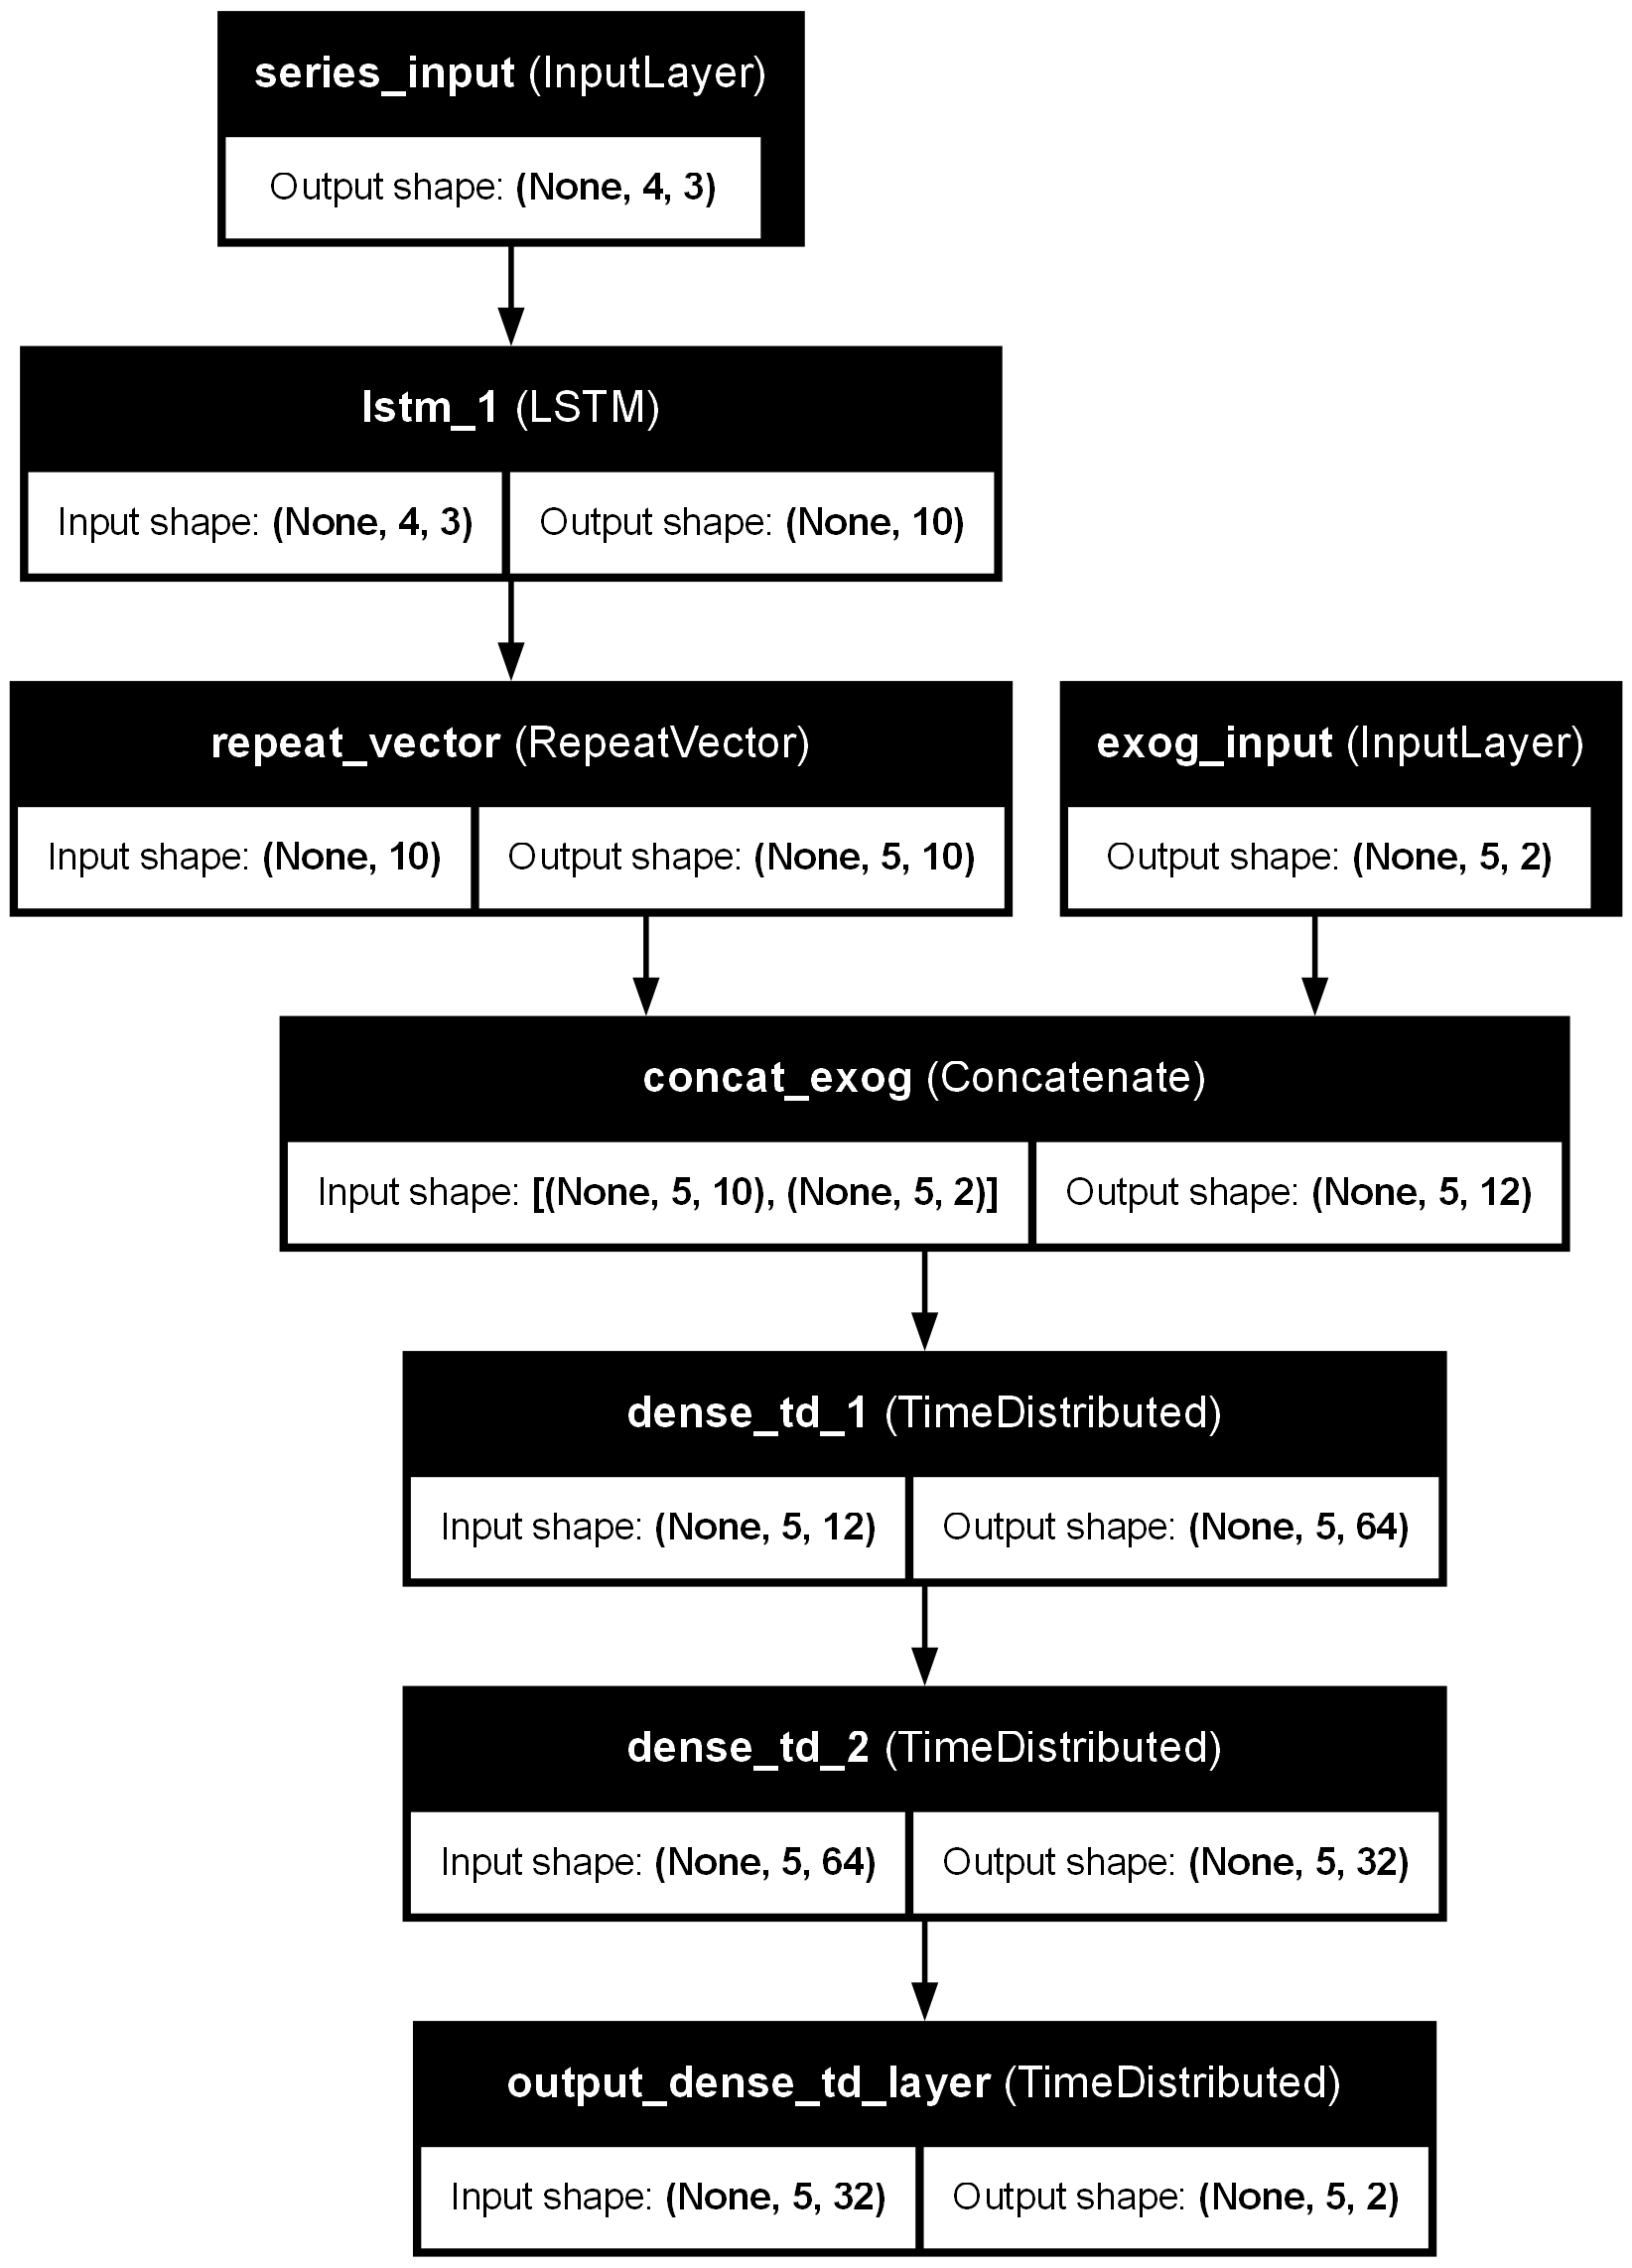

In [7]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [2]:
d = {'1': 1, '2': 2, '3': 3}
n = d['1']
print(n)
d.pop('1')
print(d)

1
{'2': 2, '3': 3}


In [5]:
import pandas as pd
s = pd.Series([1, 2, 3], index=['a', 'b', 'c'])
s.shape[1]

IndexError: tuple index out of range

In [12]:

# ==============================================================================

forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=None,
    transformer_exog=None,
    fit_kwargs={
        "epochs": 2,  # Number of epochs to train the model.
        "batch_size": 64,  # Batch size to train the model.
    },
)    



In [80]:
_ = forecaster.create_train_X_y(series = df_naive_train[series], exog = df_naive_train[exog])
_[0].shape

(19696, 4, 3)

In [81]:
_[-1]["X_train"]

{0: DatetimeIndex(['2019-01-01 04:00:00', '2019-01-01 05:00:00',
                '2019-01-01 06:00:00', '2019-01-01 07:00:00',
                '2019-01-01 08:00:00', '2019-01-01 09:00:00',
                '2019-01-01 10:00:00', '2019-01-01 11:00:00',
                '2019-01-01 12:00:00', '2019-01-01 13:00:00',
                ...
                '2021-03-31 10:00:00', '2021-03-31 11:00:00',
                '2021-03-31 12:00:00', '2021-03-31 13:00:00',
                '2021-03-31 14:00:00', '2021-03-31 15:00:00',
                '2021-03-31 16:00:00', '2021-03-31 17:00:00',
                '2021-03-31 18:00:00', '2021-03-31 19:00:00'],
               dtype='datetime64[ns]', length=19696, freq='h'),
 1: ['lag_1', 'lag_2', 'lag_3', 'lag_4'],
 2: ['l1', 'l2', 'l3']}

In [82]:
forecaster.fit(series = df_naive_train[series], exog = df_naive_train[exog], store_in_sample_residuals=True)

Using device: cuda
Epoch 1/2


c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['series_input', 'exog_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1772
Epoch 2/2
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.3469e-15


In [83]:
19696*5

98480

In [84]:
forecaster.in_sample_residuals_

{'l1': array([0., 0., 0., ..., 0., 0., 0.], shape=(10000,)),
 'l2': array([0., 0., 0., ..., 0., 0., 0.], shape=(10000,))}

In [85]:
forecaster.predict(exog=df_naive_val[exog])

,level,pred
2021-04-01 00:00:00,l1,1.0
2021-04-01 00:00:00,l2,2.0
2021-04-01 01:00:00,l1,1.0
2021-04-01 01:00:00,l2,2.0
2021-04-01 02:00:00,l1,1.0
2021-04-01 02:00:00,l2,2.0
2021-04-01 03:00:00,l1,1.0
2021-04-01 03:00:00,l2,2.0
2021-04-01 04:00:00,l1,1.0
2021-04-01 04:00:00,l2,2.0


In [87]:
forecaster.predict_interval(exog=df_naive_val[exog], interval=0.95)

,level,pred,lower_bound,upper_bound
2021-04-01 00:00:00,l1,1.0,1.0,1.0
2021-04-01 00:00:00,l2,2.0,2.0,2.0
2021-04-01 01:00:00,l1,1.0,1.0,1.0
2021-04-01 01:00:00,l2,2.0,2.0,2.0
2021-04-01 02:00:00,l1,1.0,1.0,1.0
2021-04-01 02:00:00,l2,2.0,2.0,2.0
2021-04-01 03:00:00,l1,1.0,1.0,1.0
2021-04-01 03:00:00,l2,2.0,2.0,2.0
2021-04-01 04:00:00,l1,1.0,1.0,1.0
2021-04-01 04:00:00,l2,2.0,2.0,2.0


In [46]:
print("lags:", lags)
print("steps:", steps)
print("series:", series)
print("exog:", exog)
print("levels:", levels)

_ = forecaster._create_predict_inputs(exog=df_naive_val[exog])
print(_)
_[0][0].shape

lags: 4
steps: 5
series: ['l1', 'l2', 'l3']
exog: ['exog1', 'exog2']
levels: ['l1', 'l2']
([array([[[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]]]), array([[[4., 5.],
        [4., 5.],
        [4., 5.],
        [4., 5.],
        [4., 5.]]])], {'X_autoreg': {}, 'exog_pred': {0: DatetimeIndex(['2021-04-01 00:00:00', '2021-04-01 01:00:00',
               '2021-04-01 02:00:00', '2021-04-01 03:00:00',
               '2021-04-01 04:00:00'],
              dtype='datetime64[ns]', freq=None), 1: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'exog1', 'exog2'], 2: 'series_names_in_'}}, [1, 2, 3, 4, 5], ['l1', 'l2'], DatetimeIndex(['2021-04-01 00:00:00', '2021-04-01 01:00:00',
               '2021-04-01 02:00:00', '2021-04-01 03:00:00',
               '2021-04-01 04:00:00'],
              dtype='datetime64[ns]', freq=None))


(1, 4, 3)

In [52]:
forecaster.predict(exog=df_naive_val[exog])

,level,pred
2021-04-01 00:00:00,l1,1.0
2021-04-01 00:00:00,l2,2.0
2021-04-01 01:00:00,l1,1.0
2021-04-01 01:00:00,l2,2.0
2021-04-01 02:00:00,l1,1.0
2021-04-01 02:00:00,l2,2.0
2021-04-01 03:00:00,l1,1.0
2021-04-01 03:00:00,l2,2.0
2021-04-01 04:00:00,l1,1.0
2021-04-01 04:00:00,l2,2.0


In [59]:
forecaster.in_sample_residuals_

{1: array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], shape=(19696, 2)),
 2: array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], shape=(19696, 2)),
 3: array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], shape=(19696, 2)),
 4: array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], shape=(19696, 2)),
 5: array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], shape=(19696, 2))}

In [55]:
steps = 0

if not isinstance(steps, int) or steps < 1:
    raise TypeError(
        f"`steps` argument must be an int greater than or equal to 1. "
        f"Got {type(steps)}."
    )

TypeError: `steps` argument must be an int greater than or equal to 1. Got <class 'int'>.